# Plotting vector polygon data of Europe with GeoPandas and Matplotlib

Data used:

- <https://www.naturalearthdata.com/downloads/50m-cultural-vectors/>

Install the following packages:

- cartopy
- geopandas
- scipy
- pooch
- mapclassify
- contextily

In [1]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pooch
# import contextily as cx
import shapely
from matplotlib import patheffects

In [2]:
# # basemap cache directory
# cx.set_cache_dir(os.path.join("data", "basemaps"))

## Data

In [2]:
FILE_NAME = "ne_50m_admin_0_countries.zip"
URL = "https://naciscdn.org/naturalearth/50m/cultural/" + FILE_NAME
SUB_DIR = os.path.join("data", "naturalearth")
DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)
os.makedirs(SUB_DIR, exist_ok=True)

In [4]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(url=URL, known_hash=None, fname=FILE_NAME, path=SUB_DIR)

SHA256 hash of downloaded file: 5fed433373581fa648920435f937d95f2d3c0200e067409c6478dcdf1b853139
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [3]:
ne = gpd.read_file(f"zip://{DATA_FILE}!{FILE_NAME[:-4]}.shp")

In [22]:
ne.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# keep European countries only and clip to extent
ne = ne[
    (ne["CONTINENT"] == "Europe")
    & (ne["TYPE"].isin(["Country", "Sovereign country"]))
]
ne = ne.dissolve(by=["SOVEREIGNT"], aggfunc="last")
ne.reset_index(inplace=True)
ne = gpd.clip(ne, mask=(-25, 34, 62, 72))

In [5]:
# reproject to a projected CRS for plotting
# see https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
# for more projections
ne.to_crs(ccrs.TransverseMercator(), inplace=True)

In [25]:
ne.crs

<Projected CRS: +proj=tmerc +ellps=WGS84 +lon_0=0.0 +lat_0=0.0 +k= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# generate some random data (with a missing entry) for the choropleth map
ne["RAND"] = np.random.default_rng(seed=99).integers(
    low=-20, high=20, size=len(ne)
)
ne.loc[34, "RAND"] = np.nan

In [7]:
# keep only necessary columns
ne = ne[["NAME_LONG", "ISO_A2_EH", "RAND", "geometry"]]

In [28]:
ne

,NAME_LONG,ISO_A2_EH,RAND,geometry
12,France,FR,18.0,"MULTIPOLYGON (((780888.919 4760747.432, 782685..."
27,Netherlands,NL,0.0,"MULTIPOLYGON (((282042.000 5687332.807, 272645..."
38,Spain,ES,10.0,"MULTIPOLYGON (((121940.603 4287401.686, 123217..."
31,Portugal,PT,2.0,"POLYGON ((-688527.587 4698080.770, -683608.876..."
1,Andorra,AD,-13.0,"POLYGON ((140230.432 4708955.566, 137981.385 4..."
25,Monaco,MC,0.0,"POLYGON ((599194.958 4873069.347, 594471.344 4..."
40,Switzerland,CH,17.0,"POLYGON ((716943.293 5309672.106, 719407.902 5..."
20,Liechtenstein,LI,18.0,"POLYGON ((727603.469 5258357.230, 721616.076 5..."
22,Luxembourg,LU,18.0,"POLYGON ((437277.487 5572248.051, 436935.567 5..."
4,Belgium,BE,4.0,"POLYGON ((294137.148 5703564.888, 299749.039 5..."


## Plot

### Using colorbar of absolute values

In [8]:
# map extent
minx, miny, maxx, maxy = (
    gpd.GeoSeries(shapely.geometry.box(-15, 33, 31, 72), crs=4326)
    .to_crs(ccrs.TransverseMercator())
    .total_bounds
)

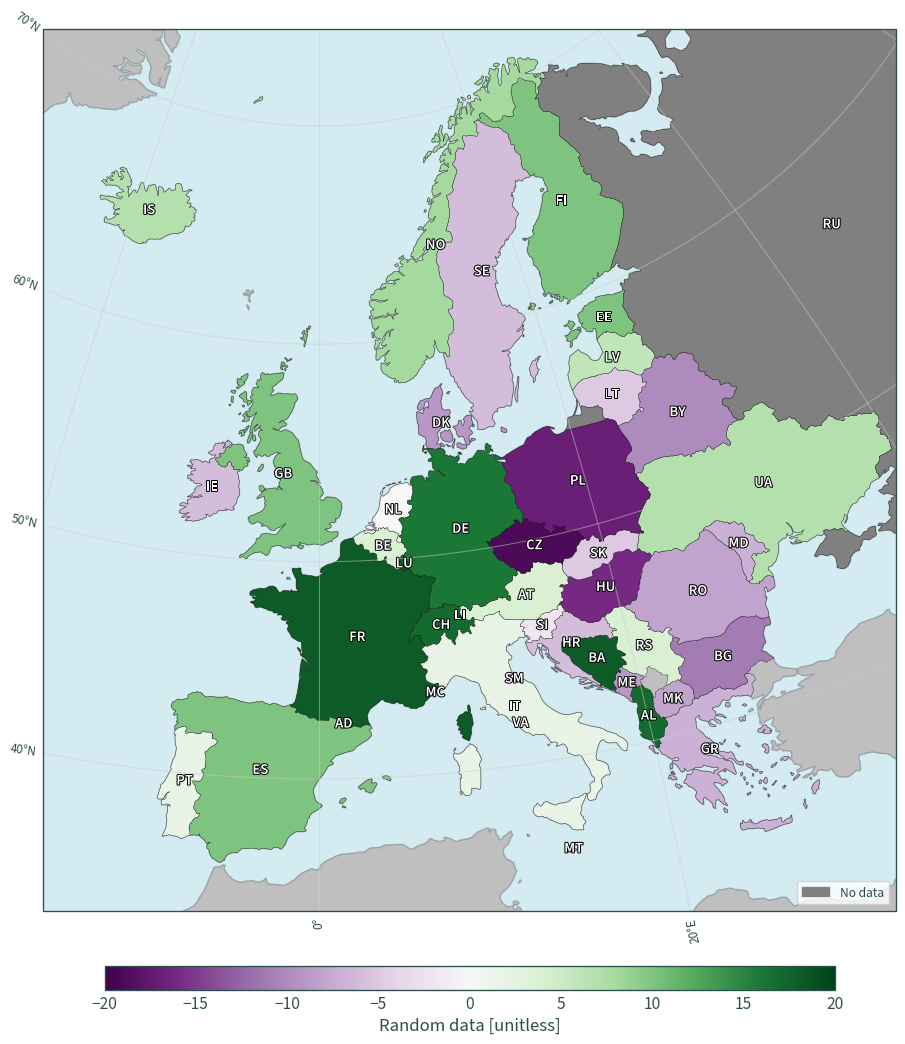

In [10]:
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
ne.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    cmap="PRGn",
    legend_kwds={
        "label": "Random data [unitless]",
        "orientation": "horizontal",
        "shrink": 0.65,
        "pad": 0.05,
        "aspect": 30,
    },
    vmax=20,  # colourbar max value
    vmin=-20,  # colourbar min value
    missing_kwds={
        "color": "grey",
    },
    ax=ax,
)

# map extent
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

# if you have entries with missing data, configure missing_kwds above and
# include the following legend
ax.legend(
    handles=[mpatches.Patch(color="grey", label="No data")], loc="lower right"
)

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(ne.centroid.x, ne.centroid.y), ne["ISO_A2_EH"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab,
        xy=xy,
        rotation=0,
        va="center",
        ha="center",
        path_effects=[
            patheffects.withStroke(linewidth=1.5, foreground="black")
        ],
        fontweight="semibold",
        fontsize=11,
        color="white",
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
# cx.add_basemap(
#     ax, source=cx.providers.CartoDB.PositronNoLabels,
#     crs=ccrs.TransverseMercator(), zoom=5
# )
ax.add_feature(cfeature.OCEAN, color="lightblue", alpha=0.5)
ax.add_feature(cfeature.LAND.with_scale("50m"), color="grey", alpha=0.5)

plt.title(None)
plt.tight_layout()
plt.show()

### Using classification

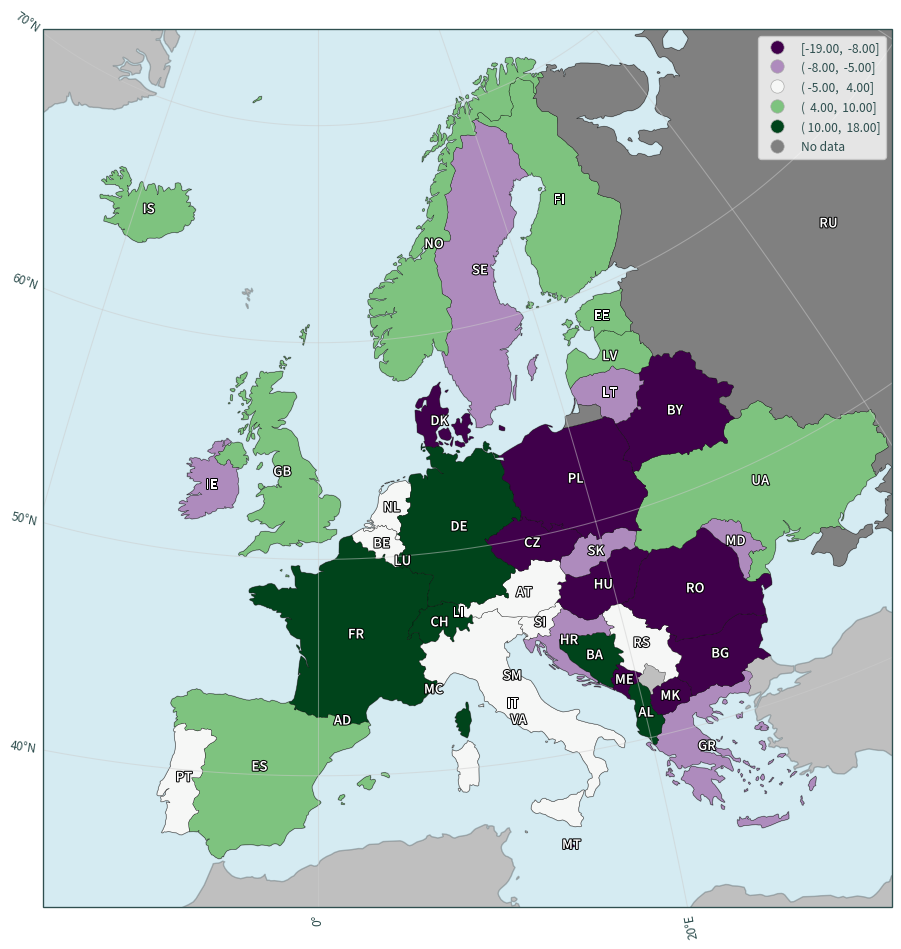

In [31]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# see here for classification methods
# https://geopandas.org/en/stable/docs/user_guide/mapping.html#choosing-colors
ne.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    legend_kwds={"interval": True},
    cmap="PRGn",
    missing_kwds={"color": "grey", "label": "No data"},
    ax=ax,
    scheme="quantiles",
)

# map extent
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.5)
    legend_handle.set_markeredgecolor("darkgrey")

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(ne.centroid.x, ne.centroid.y), ne["ISO_A2_EH"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab,
        xy=xy,
        rotation=0,
        va="center",
        ha="center",
        path_effects=[
            patheffects.withStroke(linewidth=1.5, foreground="black")
        ],
        fontweight="semibold",
        fontsize=11,
        color="white",
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
# cx.add_basemap(
#     ax, source=cx.providers.CartoDB.PositronNoLabels,
#     crs=ccrs.TransverseMercator(), zoom=5
# )
ax.add_feature(cfeature.OCEAN, color="lightblue", alpha=0.5)
ax.add_feature(cfeature.LAND.with_scale("50m"), color="grey", alpha=0.5)

plt.title(None)
plt.tight_layout()
plt.show()